In [1]:
import numpy as np
import networkx as nx
import csv
from matplotlib import pyplot
from IPython import display
from sklearn import cluster
from mpl_toolkits import mplot3d

euclidean_distance = nx.generators.geometric.euclidean

class SOM:
    def __init__(self, dataset, number_of_nodes=10):
        """A basic SOM implementation.
        :param number_of_nodes: Number of nodes in the resulting SOM graph.
        :param dataset: A n-dimensional dataset that the SOM should be computed for.
        """
        self.dataset = dataset
        self.l = number_of_nodes
        self.graph = None

        self.data_nodes = self.get_data_nodes(dataset)

    def get_data_nodes(self, dataset):
        """Extracts coordinates for x,y,z from given dataset.
        :param dataset: CSV file containing x,y,z coordinates.
        """
        data_nodes = {
            'x': [],
            'y': [],
            'z': []
        }

        # Read data and extract the columns as x,y,z coordinates
        data_read = open(dataset, 'r')
        data = csv.reader(data_read, delimiter=",", quotechar='|')

        for row in data:
            data_nodes['x'].append(float(row[0]))  # Column 1
            data_nodes['y'].append(float(row[1]))  # Column 2
            data_nodes['z'].append(float(row[2]))  # Column 3

        data_read.close()

        return data_nodes

    def train(self, t_max=1000, circular=True):
        """This method trains the SOM graph on the dataset given.
        :param number_of_nodes: Number of nodes in the resulting SOM graph.
        :param dataset: A n-dimensional dataset that the SOM should be computed for.
        :param t_max:
        :param circular: States if the resulting SOM graph should be circular.
        :returns: NetworkX Graph
        """
        graph = nx.Graph()

        # Create number of nodes
        for i in range(self.l):
            # Add a new node
            graph.add_node(i, w=self.get_random_position(
                self.data_nodes['x'],
                self.data_nodes['y'],
                self.data_nodes['z']
            ))

            # If there is a previous node
            if i - 1 in graph.nodes:
                graph.add_edge(i - 1, i)

        D = np.array(nx.floyd_warshall_numpy(graph))

        # Add the edge that makes the graph circular
        if circular:
            graph.add_edge(self.l - 1, 0)

        self.plot_all(graph)
        winner_sum = 0
        for t in range(t_max):
            # Training Loop

            # Select random datapoint x
            x = self.random_x()

            # Learning rate
            lr = 1 - (t / t_max)

            # Topological adaption rate
            tar = np.exp(-(t / t_max))

            # Get the winner neuron
            distances = {}
            for node_id, data in graph.nodes(data=True):
                distances[np.square((euclidean_distance(data['w'], x)))] = node_id

            winner = distances[min(distances)]
            winner_sum += winner
            # Update other positions
            for node_id, data in graph.nodes(data=True):

                # Determine new coordinates
                new_w = self.compute_vector(data['w'],
                                            self.compute_vector(
                                                self.compute_vector(
                                                    x,
                                                    data['w'],
                                                    t='sub'
                                                ),
                                                lr * np.exp(-(D[winner][node_id] / (2.0 * tar))),
                                                scalar=True,
                                                t='mult'
                                            ),
                                            t='add'
                                            )

                graph.nodes[node_id]['w'] = new_w
        error = winner_sum/1327
        print("error: ", winner_sum/1327 )
            # Plots every 125th step (updates in Jupyter Notebook)
#             if not t % 125:
#                 self.plot_all(graph, highlight=x, highlight_b=graph.nodes[winner]['w'])

        self.plot_all(graph)
        self.graph = graph

        return graph, error

    def plot_all(self, graph=None, highlight=None, highlight_b=None, overlap=None):
        """Plots data_nodes and graph nodes.
        :param graph: Graph to plot.
        :param highlight: Coordinates to highlight.
        :param highlight_b: Coordinates to highlight.
        :param overlap: Data to overlap with given self.data_nodes.
        """
        graph_nodes = {
            'x': [],
            'y': [],
            'z': []
        }
        if graph is not None:
            for _, data in graph.nodes(data=True):
                graph_nodes['x'].append(data['w'][0])
                graph_nodes['y'].append(data['w'][1])
                graph_nodes['z'].append(data['w'][2])

            graph_nodes['x'].append(graph_nodes['x'][0])
            graph_nodes['y'].append(graph_nodes['y'][0])
            graph_nodes['z'].append(graph_nodes['z'][0])

        fig = pyplot.figure(figsize=(20, 15))
        ax = fig.add_subplot(111, projection='3d')

        # X and Y are swapped to fit the figures on Project 03 sheet
        ax.plot(self.data_nodes['y'], self.data_nodes['x'], self.data_nodes['z'], '.', color="black", markersize=5)

        if highlight is not None:
            ax.plot([highlight[1]], [highlight[0]], [highlight[2]], 'y.', markersize=15)

        if graph is not None:
            ax.plot(graph_nodes['y'], graph_nodes['x'], graph_nodes['z'], 'b^-', markersize=5)
            ax.plot(
                [graph_nodes['y'][0], graph_nodes['y'][-1]],
                [graph_nodes['x'][0], graph_nodes['x'][-1]],
                [graph_nodes['z'][0], graph_nodes['z'][-1]],
                'b-'
            )

        if highlight_b is not None:
            ax.plot([highlight_b[1]], [highlight_b[0]], [highlight_b[2]], 'g^', markersize=5)

        if overlap is not None:
            ax.plot(overlap['y'], overlap['x'], overlap['z'], 'b.', markersize=5)

        ax.set_xlabel("X-Axis")
        ax.set_ylabel("Y-Axis")
        ax.set_zlabel("Z-Axis")

#         ax.invert_yaxis()
        ax.view_init(elev=50.)

        display.clear_output(wait=True)
        pyplot.show()

    def random_x(self):
        """Selects a random datapoint from data_nodes"""

        # Select random node in data
        rnd = np.random.randint(len(self.data_nodes['x']))

        # Resulting random position of the node
        pos = (
            self.data_nodes['x'][rnd],
            self.data_nodes['y'][rnd],
            self.data_nodes['z'][rnd]
        )

        return pos

    def compute_vector(self, v1, v2, scalar=False, t='sub'):
        """Helper function to do a simple vector calculations.
        :param v1: Vector 1
        :param v2: Vector 2 or scalar value.
        :param scalar: Flag to determine if v2 is scalar.
        :param t: Type of calculation to perform (sub-traction, add-ition, mult-iplication (only scalar))
        """
        result = None
        if t == 'sub':
            if not scalar:
                result = (v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2])
            else:
                result = (v1[0] - v2, v1[1] - v2, v1[2] - v2)
        elif t == 'add':
            if not scalar:
                result = (v1[0] + v2[0], v1[1] + v2[1], v1[2] + v2[2])
            else:
                result = (v1[0] + v2, v1[1] + v2, v1[2] + v2)
        elif t == 'mult':
            if not scalar:
                raise Exception("No vector multiplication implemented!")
            else:
                result = (v1[0] * v2, v1[1] * v2, v1[2] * v2)

        return result

    def get_random_position(self, x, y, z):
        """Generates a random position using given x,y,z lists.
        :param x: List of x coordinates used to determine upper and lower border.
        :param y: List of y coordinates (like x)
        :param z: List of z coordinates (like x)
        """
        return (
            np.random.uniform(min(x), max(x)),
            np.random.uniform(min(y), max(y)),
            np.random.uniform(min(z), max(z))
        )

    def bayesian_imitation(self, creation_steps=1000):
        """Performs a bayesian imitation.
        :param creation_steps: Number of steps to take for trajectory creation.
        """

        # list of X
        X = []

        for i, x in enumerate(self.data_nodes['x']):
            X.append((x, self.data_nodes['y'][i], self.data_nodes['z'][i]))

        if creation_steps > len(X):
            print("Creation_steps is set to len(X).")
            creation_steps = len(X)

        # List of A
        A = self.get_activity_vectors()

        # Generate KMeans clustering on A
        km = cluster.KMeans(n_clusters=self.l, n_init=1).fit(A)

        # list of S
        S = []
        for _, data in self.graph.nodes(data=True):
            S.append((data['w'][0], data['w'][1], data['w'][2]))

        # list of R
        R = km.cluster_centers_

        # mapping x
        x_map = {}
        for x in X:
            distances = {}
            for s in S:
                distances[euclidean_distance(x, s)] = s

            x_map[x] = tuple(distances[min(distances)])

        # mapping a
        a_map = {}
        for a in A:
            distances = {}
            for r in R:
                distances[euclidean_distance(a, r)] = r

            a_map[a] = tuple(distances[min(distances)])

        # p(s_i, r_j)
        p = {}
        for i, x in enumerate(X):
            if i + 1 < len(X):
                a = A[i]
                s = x_map[x]
                r = a_map[a]

                if s in p:
                    if r in p[s]:
                        p[s][r] += 1
                    else:
                        p[s][r] = 1
                else:
                    p[s] = {r: 1}

        # Create some trajectories
        trajectory = {
            'x': [],
            'y': [],
            'z': []
        }

        traj_list = []

        x_t_p = None

        for t in range(creation_steps):
            if x_t_p is None:
                rnd = np.random.randint(len(X))
                x_t = X[rnd]
            else:
                x_t = x_t_p

            trajectory['x'].append(x_t[0])
            trajectory['y'].append(x_t[1])
            trajectory['z'].append(x_t[2])

            traj_list.append((x_t[0], x_t[1], x_t[2]))

            a_t = None
            m = 0

            # closest state vector
            s = x_map[x_t]

            for r in p[s]:
                prs = p[s][r]
                total = 0
                for rq in p[s]:
                    total += p[s][rq]

                res = prs / len(A)

                # pick max
                if res > m:
                    m = res
                    a_t = r

            # Compute next state
            x_t_p_candidate = self.compute_vector(x_t, a_t, t='add')

            dist = np.inf
            for x in X:
                ed = euclidean_distance(x_t_p_candidate, x)

                if ed < dist:

                    # Make sure one does not revisit nodes.
                    if x not in traj_list:
                        x_t_p = x
                        dist = ed

        return trajectory

    def get_activity_vectors(self):
        """Helper function to generate activity vectors."""

        actions = []

        for i, x in enumerate(self.data_nodes['x']):
            y = self.data_nodes['y'][i]
            z = self.data_nodes['z'][i]

            if i-1 > -1:
                actions.append((x - self.data_nodes['x'][i-1],
                                y - self.data_nodes['y'][i-1],
                                z - self.data_nodes['z'][i-1]))

        return actions

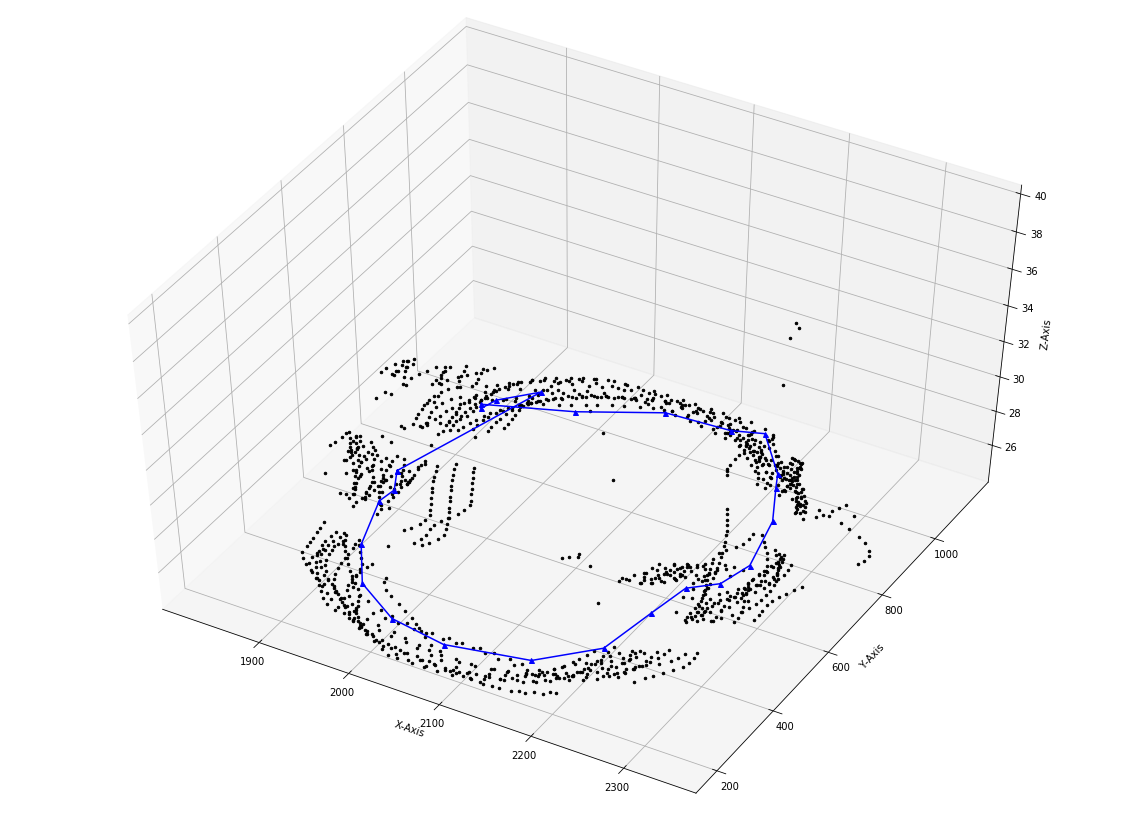

Error:  8.39638281838734


In [2]:
som = SOM("q3dm1-path1.csv",24)
graph, error = som.train()
print("Error: ", error)